# Setting

In [1]:
import pymc3 as pm
import arviz
from matplotlib import gridspec
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from scipy import stats

import numpy as np
import pandas as pd

plt.rcParams['font.family'] = 'NanumGothic'

In [2]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [3]:
def print_interval(low, high, text='confidence interval: '):
    #low, high = low*100, high*100
    p = (low+high)/2
    err = high - p
    #print(f'confidence interval: {p:.0f} ± {err:.2f} % [{low:.0f}, {high:.0f}]')
    print(f'{text}{p:.3f} ± {err:.4f}, [{low:.3f}, {high:.3f}]')
    
    
def test_hypothesis(pvalue, level=0.95):
    alpha = 1 - c_level
    if pvalue > alpha:
        s = 'Accept'
    else:
        s = 'Reject'
    print(f'{s} H0 (p-value = {pvalue:.4e})')

In [4]:
def plot_survey(results, category_names, ax=None, fig=None, figsize=(10, 5), fmt='%1.1f%%', cmap='Spectral', margin=0.25):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    cmap: 
        ex) 'bwr', 'coolwarm'
        see https://matplotlib.org/stable/tutorials/colors/colormaps.html
    fmt: ex) '%g', '%1.1f%%'
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps[cmap](
        np.linspace(margin, 1-margin, data.shape[1]))
        #np.linspace(0.25, 0.75, data.shape[1]))
        
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        height = figsize[1]
    else:
        if fig is None:
            print('ERROR: set fig')
            return None
        else:
            height = fig.get_figheight()
    height = height/len(results)*.8        
        
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=height,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, fmt=fmt, label_type='center', color=text_color, fontweight='bold')
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    
    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    ax.yaxis.set_tick_params(left=False)
    
    #return fig, ax
    return ax


# sample
category_names = ['Strongly disagree', 'Disagree',
                  'Neither agree nor disagree', 'Agree', 'Strongly agree']
results = {
    'Question 1': [10, 15, 17, 32, 26],
    'Question 2': [26, 22, 29, 10, 13],
    'Question 3': [35, 37, 7, 2, 19],
    'Question 4': [32, 11, 9, 15, 33],
    'Question 5': [21, 29, 5, 5, 40],
    'Question 6': [8, 19, 5, 30, 38]
}

#_ = plot_survey(results, category_names)
#plt.show()

In [5]:
def plot_groupbar(df, figsize=(10,5), axis=0):
    if axis > 0:
        df = df.T
        
    xticks = df.columns
    data_dict = df.to_dict(orient='split')
    data_dict = dict(zip(data_dict['index'], data_dict['data']))
    
    x = np.arange(len(xticks))  # the label locations
    width = 1 / (len(data_dict)+1)
    multiplier = 0
    
    fig, ax = plt.subplots(layout='constrained', figsize=figsize)

    for attribute, measurement in data_dict.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_xticks(x + width, xticks)
    ax.legend(bbox_to_anchor=(1, 1))
    ax.tick_params(axis='x', labelrotation = 45)
    plt.show()

In [6]:
l_tab = 6

def print_head(x, x_all, l_tab=l_tab, n_tab=None):
    if n_tab is None:
        n_tab = max([len(x) // l_tab + min(len(x) % l_tab, 1) for x in x_all])
    n = n_tab - len(x) // l_tab
    t = '\t' * n
    print(f'{x}{t}', end=' ')

In [8]:
def evaluate_contingency(df, q):
    """
    성별과 질문의 상관관계, 세대와 질문의 상관관계 검토
    q: 긍정/부정의 질문 내용.
    """
    midx = pd.IndexSlice
    get_idx = lambda x, y: midx[:, x] if y > 0 else x

    cat = {}
    for i in range(2):
        k = df.index.get_level_values(i).unique()
        n = df.index.get_level_values(i).nunique()
        cat.update(dict(zip(k, [i]*n)))

    
    h0t = {0: '성별과', 1: '세대와'} # var for level (key)
    h0 = 'H0:({}) {} {}의 상관관계가 없다'
    h0s = [h0.format(k, h0t[v], q) for k, v in cat.items()]
    num = len(h0s)
    
    h0t = {0: '세대와', 1: '성별과'}
    h0 = 'H0:{} {}의 상관관계가 없다'
    h0s = h0s + [h0.format(h0t[v], q) for v in range(2)]
    cnt_lvl = {0:0, 1:0}
    
    for i, (k,v) in enumerate(cat.items()):
        y = df.loc[get_idx(k, v), :]
        if y.shape[0] > 1:
            print_head(h0s[i], h0s)
            res = stats.chi2_contingency(y)
            test_hypothesis(res[1])
            cnt_lvl[v] += 1
   
    for i in range(1,-1,-1):
        y = df.groupby(level=i).sum()
        if cnt_lvl[i] > 1:
            print_head(h0s[i+num], h0s)
            res = stats.chi2_contingency(y)
            test_hypothesis(res[1]) 

In [81]:
list(range(1, -1, -1))

[1, 0]

In [82]:
def evaluate_contingency(df, q, level=['세대와', '성별과']):
    """
    성별과 질문의 상관관계, 세대와 질문의 상관관계 검토
    q: 긍정/부정의 질문 내용.
    """
    midx = pd.IndexSlice
    get_idx = lambda x, y: midx[:, x] if y > 0 else x

    cat = {}
    for i in range(2):
        k = df.index.get_level_values(i).unique()
        n = df.index.get_level_values(i).nunique()
        cat.update(dict(zip(k, [i]*n)))

    
    h0t = dict(zip(range(1, -1, -1), level)) # var for level (key)
    h0 = 'H0:({}) {} {}의 상관관계가 없다'
    h0s = [h0.format(k, h0t[v], q) for k, v in cat.items()]
    num = len(h0s)
    
    h0t = dict(zip(range(2), level))
    h0 = 'H0:{} {}의 상관관계가 없다'
    h0s = h0s + [h0.format(h0t[v], q) for v in range(2)]
    cnt_lvl = {0:0, 1:0}
    
    for i, (k,v) in enumerate(cat.items()):
        y = df.loc[get_idx(k, v), :]
        if y.shape[0] > 1:
            print_head(h0s[i], h0s)
            res = stats.chi2_contingency(y)
            test_hypothesis(res[1])
            cnt_lvl[v] += 1
   
    for i in range(1,-1,-1):
        y = df.groupby(level=i).sum()
        if cnt_lvl[i] > 1:
            print_head(h0s[i+num], h0s)
            res = stats.chi2_contingency(y)
            test_hypothesis(res[1]) 

In [9]:
c_level = .95 # 신뢰수준 95%
alpha = 1 - c_level # 유의수준 5%

# F01 신뢰수준과 표본오차
전국 성인 남녀 1000명이 조사에 응해주었다. 응답률은 5.4%, 표본오차는 95% 신뢰수준에서 ±3.1%포인트다

comments:
- 한 개의 긍정/부정 문항에 대하여 1000명 중 50%가 긍정한다면 100번중 95번의 경우 오차는 ±3.1% 이내. 
- 기사중 20대 여성은 160명이므로 20대 여성의 긍정/부정 문항의 최대 표본오차는 95% 신뢰수준에서 ±7.8% 

In [10]:
# 전체
n = 1000
k = round(n/2)

method = 'normal'
low, high = proportion_confint(k, n, alpha, method=method)
print(f'method = {method}')
print_interval(low, high)

method = 'wilson'
low, high = proportion_confint(k, n, alpha, method=method)
print(f'method = {method}')
print_interval(low, high)

method = 'jeffreys'
low, high = proportion_confint(k, n, alpha, method=method)
print(f'method = {method}')
print_interval(low, high)

method = normal
confidence interval: 0.500 ± 0.0310, [0.469, 0.531]
method = wilson
confidence interval: 0.500 ± 0.0309, [0.469, 0.531]
method = jeffreys
confidence interval: 0.500 ± 0.0310, [0.469, 0.531]


In [11]:
# 20대 여성
n = 160
k = round(n/2)

method = 'normal'
low, high = proportion_confint(k, n, alpha, method=method)
print(f'method = {method}')
print_interval(low, high)

method = 'wilson'
low, high = proportion_confint(k, n, alpha, method=method)
print(f'method = {method}')
print_interval(low, high)

method = 'jeffreys'
low, high = proportion_confint(k, n, alpha, method=method)
print(f'method = {method}')
print_interval(low, high)

method = normal
confidence interval: 0.500 ± 0.0775, [0.423, 0.577]
method = wilson
confidence interval: 0.500 ± 0.0766, [0.423, 0.577]
method = jeffreys
confidence interval: 0.500 ± 0.0769, [0.423, 0.577]


In [12]:
# 20대 여성
n = 160
k = round(n*.96)

method = 'normal'
low, high = proportion_confint(k, n, alpha, method=method)
print(f'method = {method}')
print_interval(low, high)

method = 'wilson'
low, high = proportion_confint(k, n, alpha, method=method)
print(f'method = {method}')
print_interval(low, high)

method = 'jeffreys'
low, high = proportion_confint(k, n, alpha, method=method)
print(f'method = {method}')
print_interval(low, high)

method = normal
confidence interval: 0.963 ± 0.0294, [0.933, 0.992]
method = wilson
confidence interval: 0.952 ± 0.0310, [0.921, 0.983]
method = jeffreys
confidence interval: 0.954 ± 0.0299, [0.924, 0.984]


# F02 미혼의 결혼 의향
- 그림1. 
- 대상: 미혼 579명
- (그림에 없는 내용) 그런데 여기서 남녀 성별 격차가 나타난다. 미혼 남성은 65.7%가 결혼하고 싶다고 답한다. 그러나 여성은 54.5%가 결혼할 의향이 없다고 답한다. 
- 결혼 의향에 대해서 "남녀 간 ‘미스매치’가 일어난다. 이 성별 격차는 결혼 적령기인 30대에서 가장 크다"고 한다.

comments:
- (기사대로) 미혼남녀 및, 2030대 젊은 세대의 남녀 간 격차가 있다. 단 20대의 경우 아슬아슬하게 성별 차이가 있다(p-value 0.035). 
- 세대별 차이는 없다.
- (기사의 뉘앙스?와 달리) 미혼/20대/30대에 대해 남성의 결혼 의향은 50%를 넘는다. 여성은 50% 미만이라고 할 수 없다.

In [10]:
p1 = [.565, .435]
p2 = [.646, .354]
p3 = [.473, .527]
p4 = [.711, .289]
p5 = [.447, .553]
p6 = [.657, .343] # 미혼남
p7 = [.455, .545] # 미혼여

idx = ['전체', '20대 남성', '20대 여성', '30대 남성', '30대 여성', '미혼 남성', '미혼 여성']
cols = [['결혼']*2, ['의향 있음', '의향 없음']]
df = pd.DataFrame([p1,p2,p3,p4,p5,p6,p7], index=idx, columns=cols)

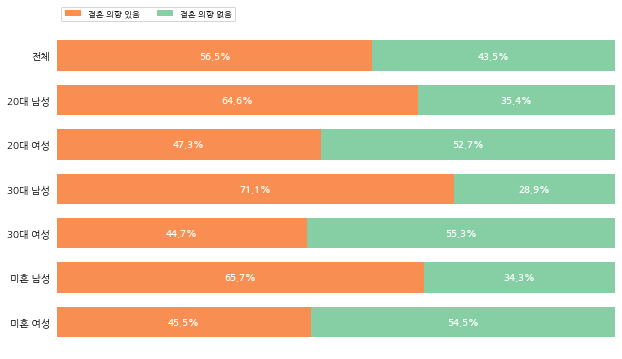

In [11]:
x = df.mul(100).to_dict(orient='split')
res = dict(zip(x['index'], x['data']))
cat = [' '.join(x) for x in x['columns']]
_ = plot_survey(res, cat, figsize=(10,6))

In [12]:
# 나이별 인원수와 남녀 비율 동일 가정
n_single = 579
n_ages = round(n_single / (49-18+1) / 2) * 10 # 세대별 미혼남
n_ages

90

In [13]:
# '전체', '20대남', '20대여', '30대남', '30대여', '미혼남', '미혼여'
nums = [n_single, n_ages, n_ages, n_ages, n_ages, round(n_single/2), n_single-round(n_single/2)]
method = 'normal'

x = ' '.join(df.columns[0])
print(f'{x}:')
for i in range(len(nums)):
    print_head(df.index[i], df.index, n_tab=2)
    n = nums[i]
    k = round(df.iloc[i,0] * n)
    low, high = proportion_confint(k, n, alpha, method=method)
    print_interval(low, high, '')

결혼 의향 있음:
전체		 0.565 ± 0.0404, [0.524, 0.605]
20대 남성	 0.644 ± 0.0989, [0.546, 0.743]
20대 여성	 0.478 ± 0.1032, [0.375, 0.581]
30대 남성	 0.711 ± 0.0936, [0.617, 0.805]
30대 여성	 0.444 ± 0.1027, [0.342, 0.547]
미혼 남성		 0.659 ± 0.0546, [0.604, 0.713]
미혼 여성		 0.453 ± 0.0574, [0.396, 0.511]


In [18]:
method = 'jeffreys'

x = ' '.join(df.columns[0])
print(f'{x}:')
for i in range(len(nums)):
    print_head(df.index[i], df.index, n_tab=2)
    n = nums[i]
    k = round(df.iloc[i,0] * n)
    low, high = proportion_confint(k, n, alpha, method=method)
    print_interval(low, high, '')

결혼 의향 있음:
전체		 0.564 ± 0.0403, [0.524, 0.605]
20대 남성	 0.640 ± 0.0976, [0.542, 0.738]
20대 여성	 0.478 ± 0.1018, [0.377, 0.580]
30대 남성	 0.704 ± 0.0925, [0.612, 0.797]
30대 여성	 0.446 ± 0.1013, [0.345, 0.548]
미혼 남성		 0.657 ± 0.0544, [0.603, 0.711]
미혼 여성		 0.454 ± 0.0572, [0.397, 0.511]


In [14]:
df2 = df.iloc[1:-2].mul(n_ages).apply(lambda x: round(x)).astype(int)
idx = df2.iloc[:,0].index.str.split(' ', expand=True)

x = df2.set_index(idx)
display(x)

evaluate_contingency(x, '결혼할 의향')

결혼      
       의향 있음 의향 없음
20대 남성    58    32
    여성    43    47
30대 남성    64    26
    여성    40    50

H0:(20대) 성별과 결혼할 의향의 상관관계가 없다	 Reject H0 (p-value = 3.5487e-02)
H0:(30대) 성별과 결혼할 의향의 상관관계가 없다	 Reject H0 (p-value = 5.1874e-04)
H0:(남성) 세대와 결혼할 의향의 상관관계가 없다	 Accept H0 (p-value = 4.2518e-01)
H0:(여성) 세대와 결혼할 의향의 상관관계가 없다	 Accept H0 (p-value = 7.6490e-01)
H0:성별과 결혼할 의향의 상관관계가 없다		 Reject H0 (p-value = 5.2378e-05)
H0:세대와 결혼할 의향의 상관관계가 없다		 Accept H0 (p-value = 8.3142e-01)


In [15]:
df2 = df.iloc[-2:].mul(n_single).apply(lambda x: round(x)).astype(int)
idx = df2.iloc[:,0].index.str.split(' ', expand=True)

x = df2.set_index(idx)
display(x)

evaluate_contingency(x, '결혼할 의향')

결혼      
      의향 있음 의향 없음
미혼 남성   380   199
   여성   263   316

H0:(미혼) 성별과 결혼할 의향의 상관관계가 없다	 Reject H0 (p-value = 6.9020e-12)


# F03 연애-결혼-출산 인식
- 그림2 
- 대상 응답자 전체 1000명
- 30대 남성(66.9%), 40대 남성(69.1%)에 비해 오히려 연애에 적극적일 것 같은 20대 남성이 연애에 더 시큰둥하다. 남성과 여성 모두 젊을수록 연애에 대한 집착이 약하다.
- 연애도, 결혼도 필수가 아닌데 출산이 필수일 리 없다

comments:
- (기사대로) ‘결혼은 반드시 해야 한다’는 인식에 대해서도 성별 격차가 있고 여성이 결혼에 더 부정적인 것도 맞다.
- (기사대로) 결혼뿐 아니라 ‘연애’에 대해서도 이러한 성별 격차가 크게 나타난다.
- (기사대로) '연애는 반드시 해야 한다'는 문항에 ‘그렇지 않다’가 절반 이상을 차지하는 집단(연애 필수인 비율이 절반 미만)은 (결혼 의향 없는 미혼 집단 제외하고) 전체 성별·세대 가운데 20대 여성이 유일하다.
- (기사와달리) 기사대로 남성들은 전반적으로 ‘연애는 반드시 해야 한다’는 데 동의하는 태도를 보인다. 그러나 기사와 달리 30대 남성에 비해 20대 남성이 연애에 더 시큰둥하다고 할 수는 없다.
- (기사와 달리) 기사는 남성과 여성 모두 젊을수록 연애에 대한 집착이 약하다지만 여성만 젊을수록 연애에 대한 집착이 약하다
- (기사대로) ‘자녀는 반드시 낳아야 한다’는 문항에 대해서도 20대 여성은 강하게 반발한다. 결혼 의향 없는 미혼 집단을 제외하고 자녀가 필수라는 비율이 가장 낮다.
- (기사대로) 20대 여성 160명은 성별·세대 기준으로 결혼과 출산에 대해 가장 강하게 반발하는 이들이다. 여타 질문에서도 이들의 응답이 유독 튀는 경우가 잦다.
- 20대 여성 집단을 제외하고 결혼 의향 없는 미혼의 자녀 필수 비율이 가장 낮다. 비혼 출산의 가능성을 상상조차 하지 못하고 있는것 같다.
- 30대 여성은 (전체 집단 제외하고) 유일하게 결혼 필수보다 출산 필수 비율이 높다.

In [83]:
p1 = [.573, .224, .307] # 연애, 결혼, 출산의 필수 비율
p2 = [.560, .315, .355]
p3 = [.273, .083, .102]
p4 = [.669, .327, .377]
p5 = [.571, .096, .261]
p6 = [.240, .012, .071] 

idx = ['전체', '20대 남성', '20대 여성', '30대 남성', '30대 여성', '결혼 의향 없는 미혼']
cols = [['필수']*3, ['연애', '결혼', '출산']]
df = pd.DataFrame([p1,p2,p3,p4,p5,p6], index=idx, columns=cols)

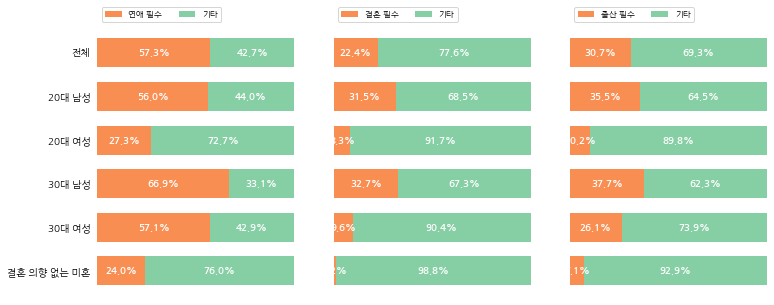

In [84]:
fig, axes = plt.subplots(1,3, figsize=(12,5), sharey=True)
for i in range(len(df.columns)):
    col = ' '.join(list(reversed(df.columns[i])))
    x = (df.iloc[:,i].to_frame(col)
           .assign(disagree=lambda x: 1-x[col])
           .rename(columns={col:col, 'disagree': '기타'})
           .mul(100).to_dict(orient='split'))
    res = dict(zip(x['index'], x['data']))
    cat = x['columns']
    _ = plot_survey(res, cat, ax=axes[i], fig=fig)

In [85]:
# 나이별 남녀인원수 동일하다는 가정하에 계산한 세대별 남녀수(예 20대 여자)는 (우연히도) 실제 20대 여자수와 동일

# 나이별 인원수와 남녀 비율 동일 가정
n_all = 1000 # 전체 응답자
n_single2 = 252 # 결혼 의향 없는 미혼
n_ages = round(n_all / (49-18+1) / 2) * 10 # 세대별 남자
n_ages

160

In [86]:
nums = [n_all, n_ages, n_ages, n_ages, n_ages, n_single2]
method = 'normal'

for c in range(len(df.columns)):
    x = list(df.columns[c])
    x.reverse()
    x = ' '.join(x)
    print(f'{x}:')

    for i in range(len(nums)):
        x = df.index[i]
        print_head(x, df.index)
        n = nums[i]
        k = round(df.iloc[i,c] * n)
        low, high = proportion_confint(k, n, alpha, method=method)
        print_interval(low, high, '')
    print()

연애 필수:
전체		 0.573 ± 0.0307, [0.542, 0.604]
20대 남성	 0.562 ± 0.0769, [0.486, 0.639]
20대 여성	 0.275 ± 0.0692, [0.206, 0.344]
30대 남성	 0.669 ± 0.0729, [0.596, 0.742]
30대 여성	 0.569 ± 0.0767, [0.492, 0.645]
결혼 의향 없는 미혼	 0.238 ± 0.0526, [0.186, 0.291]

결혼 필수:
전체		 0.224 ± 0.0258, [0.198, 0.250]
20대 남성	 0.312 ± 0.0718, [0.241, 0.384]
20대 여성	 0.081 ± 0.0423, [0.039, 0.124]
30대 남성	 0.325 ± 0.0726, [0.252, 0.398]
30대 여성	 0.094 ± 0.0452, [0.049, 0.139]
결혼 의향 없는 미혼	 0.013 ± 0.0126, [0.000, 0.025]

출산 필수:
전체		 0.307 ± 0.0286, [0.278, 0.336]
20대 남성	 0.356 ± 0.0742, [0.282, 0.430]
20대 여성	 0.100 ± 0.0465, [0.054, 0.146]
30대 남성	 0.375 ± 0.0750, [0.300, 0.450]
30대 여성	 0.263 ± 0.0682, [0.194, 0.331]
결혼 의향 없는 미혼	 0.071 ± 0.0318, [0.040, 0.103]



In [87]:
df2 = df.iloc[1:-1]
idx = df2.index.str.split(' ', expand=True)
df2 = df2.set_index(idx)

for i in range(len(df2.columns)):
    col = ' '.join(list(reversed(df2.columns[i])))
    #print(f'{col}:')
        
    x = (df2.iloc[:,i].to_frame(col)
            .assign(disagree=lambda x: 1-x[col])
            .rename(columns={col:col, 'disagree': '그외'})
            .mul(n_ages).apply(lambda x: round(x)).astype(int)
        )
    display(x)
    
    evaluate_contingency(x, col)
    
    print('\n'*1)

연애 필수   그외
20대 남성     90   70
    여성     44  116
30대 남성    107   53
    여성     91   69

H0:(20대) 성별과 연애 필수의 상관관계가 없다	 Reject H0 (p-value = 3.4159e-07)
H0:(30대) 성별과 연애 필수의 상관관계가 없다	 Accept H0 (p-value = 8.4267e-02)
H0:(남성) 세대와 연애 필수의 상관관계가 없다	 Accept H0 (p-value = 6.5960e-02)
H0:(여성) 세대와 연애 필수의 상관관계가 없다	 Reject H0 (p-value = 1.9201e-07)
H0:성별과 연애 필수의 상관관계가 없다		 Reject H0 (p-value = 1.3939e-06)
H0:세대와 연애 필수의 상관관계가 없다		 Reject H0 (p-value = 6.2253e-07)




결혼 필수   그외
20대 남성     50  110
    여성     13  147
30대 남성     52  108
    여성     15  145

H0:(20대) 성별과 결혼 필수의 상관관계가 없다	 Reject H0 (p-value = 4.1695e-07)
H0:(30대) 성별과 결혼 필수의 상관관계가 없다	 Reject H0 (p-value = 7.5640e-07)
H0:(남성) 세대와 결혼 필수의 상관관계가 없다	 Accept H0 (p-value = 9.0451e-01)
H0:(여성) 세대와 결혼 필수의 상관관계가 없다	 Accept H0 (p-value = 8.4317e-01)
H0:성별과 결혼 필수의 상관관계가 없다		 Reject H0 (p-value = 7.3769e-13)
H0:세대와 결혼 필수의 상관관계가 없다		 Accept H0 (p-value = 7.6818e-01)




출산 필수   그외
20대 남성     57  103
    여성     16  144
30대 남성     60  100
    여성     42  118

H0:(20대) 성별과 출산 필수의 상관관계가 없다	 Reject H0 (p-value = 9.8893e-08)
H0:(30대) 성별과 출산 필수의 상관관계가 없다	 Reject H0 (p-value = 4.1413e-02)
H0:(남성) 세대와 출산 필수의 상관관계가 없다	 Accept H0 (p-value = 8.1642e-01)
H0:(여성) 세대와 출산 필수의 상관관계가 없다	 Reject H0 (p-value = 2.8578e-04)
H0:성별과 출산 필수의 상관관계가 없다		 Reject H0 (p-value = 2.6943e-07)
H0:세대와 출산 필수의 상관관계가 없다		 Reject H0 (p-value = 1.3023e-02)




In [121]:
# 전체집단 모두 결혼보다 연애 필수 비율이 더 높다
# 30대 여성만이 (너무 낮은 결혼&출산 비율로 결혼의향없는 미혼 제외하고) 결혼보다 출산 필수 비율이 더 높다.
# 전체집단 모두 출산보다 연애 필수 비율이 더 높다

nums = [n_all, n_ages, n_ages, n_ages, n_ages, n_single2]

def func(items, df=df):
    a = ' & '.join(items)
    print(f'{a}:\n')
    midx = pd.IndexSlice
    df2 = df.loc[:,midx[:,items]]
    title = df2.index
    col = df.columns.get_level_values(0).unique()[0]

    for i in range(len(title)):
        #print_head(title[i], title)
        x = (df2.rename(columns={col:title[i]}).iloc[i].to_frame(col)
                .assign(disagree=lambda x: 1-x[col])
                .rename(columns={col:col, 'disagree': '그외'})
                .mul(nums[i]).apply(lambda x: round(x)).astype(int))

        #display(x)
        a = '/'.join(items)
        evaluate_contingency(x, '필수여부', ['',f'{a}과'])
        
        title2 = [f'({title[i]}) {x} {col}' for x in x.index.get_level_values(1)]
        for j in range(len(title2)):
            print_head(title2[j], title2)
            n = x.iloc[j].sum()
            k = x.iloc[j,0]
            low, high = proportion_confint(k, n, alpha, method=method)
            print_interval(low, high, '')
        print()


c = [['연애','결혼'],['결혼','출산'],['연애','출산']]
for i in c:
    func(i)
    print('-'*80)

연애 & 결혼:

H0:(전체) 연애/결혼과 필수여부의 상관관계가 없다	 Reject H0 (p-value = 6.9771e-57)
(전체) 연애 필수	 0.573 ± 0.0307, [0.542, 0.604]
(전체) 결혼 필수	 0.224 ± 0.0258, [0.198, 0.250]

H0:(20대 남성) 연애/결혼과 필수여부의 상관관계가 없다	 Reject H0 (p-value = 1.1087e-05)
(20대 남성) 연애 필수	 0.562 ± 0.0769, [0.486, 0.639]
(20대 남성) 결혼 필수	 0.312 ± 0.0718, [0.241, 0.384]

H0:(20대 여성) 연애/결혼과 필수여부의 상관관계가 없다	 Reject H0 (p-value = 1.1700e-05)
(20대 여성) 연애 필수	 0.275 ± 0.0692, [0.206, 0.344]
(20대 여성) 결혼 필수	 0.081 ± 0.0423, [0.039, 0.124]

H0:(30대 남성) 연애/결혼과 필수여부의 상관관계가 없다	 Reject H0 (p-value = 1.5652e-09)
(30대 남성) 연애 필수	 0.669 ± 0.0729, [0.596, 0.742]
(30대 남성) 결혼 필수	 0.325 ± 0.0726, [0.252, 0.398]

H0:(30대 여성) 연애/결혼과 필수여부의 상관관계가 없다	 Reject H0 (p-value = 5.1998e-19)
(30대 여성) 연애 필수	 0.569 ± 0.0767, [0.492, 0.645]
(30대 여성) 결혼 필수	 0.094 ± 0.0452, [0.049, 0.139]

H0:(결혼 의향 없는 미혼) 연애/결혼과 필수여부의 상관관계가 없다	 Reject H0 (p-value = 4.6114e-14)
(결혼 의향 없는 미혼) 연애 필수	 0.238 ± 0.0526, [0.186, 0.291]
(결혼 의향 없는 미혼) 결혼 필수	 0.013 ± 0.0126, [0.000, 0.025]

---------

# F04 결혼 관련 인식
- 그림3 
- 대상 응답자 전체 1000명
- 유독 20대 여성이 ‘희생’이라는 단어에 더 민감한 반응.
- 20대 여성 67.8%가 아무리 경제적으로 넉넉하더라도 일을 그만두어서는 안 된다고 답한다. 30대 여성의 응답(51%)보다도 높은 수치다.
- ‘자녀가 생기면 나의 사회적 성취를 이루기 어렵다’는 문항... 20대 여성은 전체 평균을 훌쩍 뛰어넘어 68.7%가 ‘그렇다’고 답했다. 30대 여성의 동일 응답(57.5%)보다 더 강한 반응이다.

comments:
- (기사대로) '결혼 관계를 위해 자신의 인생을 어느 정도 희생하는 것은 당연하다’는 문항에 대하여 유독 20대 여성이 ‘희생’이라는 단어에 더 민감한 반응을 보였다.
- (기사대로) 20대 여성은 30대 여성보다 높은 비율로 '아무리 경제적으로 넉넉하더라도 일을 그만두어서는 안 된다'고 답한다.
- (기사대로) ‘자녀가 생기면 나의 사회적 성취를 이루기 어렵다’는 문항에 대하여 '그렇다'고 대답한 비율은 20대 여성이 30대 여성과 다르다.
- 기사에서는 언급하지 않았지만 30대 남성이 눈에 띄는데 그들은 누구보다 더 결혼을 위해 희생할 준비가 되있고, (20대 남성과 함께) 결혼과 자녀가 사회적 성취에 방해된다고 생각하지 않는다.  
- 결혼을 위한 희생은 당연하다는 비율은 세대와 성별 차이가 있다. 
- 결혼/자녀가 사회적 성취에 방해된다는 비율은 세대별 차이는 없고 성별 차이가 있다. 자녀가 방해된다는 비율은 전체적으로는 세대차이가 없지만 여성에 대해서는 세대차이가 있다(20대 여성이 비율이 높다)

In [122]:
p1 = [.593, .362, .458] # 결혼을 위한 희생은 당연하다, 결혼은 사회적 성취에 방해된다, 자녀는 사회적 성취에 방해된다의 긍정 비율
p2 = [.538, .315, .373]
p3 = [.405, .475, .687]
p4 = [.724, .229, .351]
p5 = [.536, .504, .575]
p6 = [.387, .496, .627] 

idx = ['전체', '20대 남성', '20대 여성', '30대 남성', '30대 여성', '결혼 의향 없는 미혼']
cols = ['결혼을 위한 희생은 당연', '결혼은 사회적 성취에 방해', '자녀는 사회적 성취에 방해']
df = pd.DataFrame([p1,p2,p3,p4,p5,p6], index=idx, columns=cols)

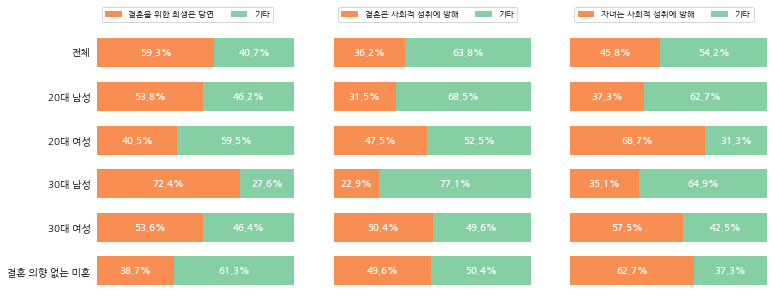

In [123]:
fig, axes = plt.subplots(1,3, figsize=(12,5), sharey=True)
for i in range(len(df.columns)):
    col = df.columns[i]
    x = (df.iloc[:,i].to_frame(col)
           .assign(disagree=lambda x: 1-x[col])
           .rename(columns={col:col, 'disagree': '기타'})
           .mul(100).to_dict(orient='split'))
    res = dict(zip(x['index'], x['data']))
    cat = x['columns']
    _ = plot_survey(res, cat, ax=axes[i], fig=fig)

In [124]:
# 나이별 남녀인원수 동일하다는 가정하에 계산한 세대별 남녀수(예 20대 여자)는 (우연히도) 실제 20대 여자수와 동일

# 나이별 인원수와 남녀 비율 동일 가정
n_all = 1000 # 전체 응답자
n_single2 = 252 # 결혼 의향 없는 미혼
n_ages = round(n_all / (49-18+1) / 2) * 10 # 세대별 남자
n_ages

160

## CS1

In [125]:
nums = [n_all, n_ages, n_ages, n_ages, n_ages, n_single2]
method = 'normal'

for c in range(len(df.columns)):
    print(f'{df.columns[c]}:')
    for i in range(len(nums)):
        x = df.index[i]
        print_head(x, df.index)
        n = nums[i]
        k = round(df.iloc[i,c] * n)
        low, high = proportion_confint(k, n, alpha, method=method)
        print_interval(low, high, '')
    print()

결혼을 위한 희생은 당연:
전체		 0.593 ± 0.0304, [0.563, 0.623]
20대 남성	 0.537 ± 0.0773, [0.460, 0.615]
20대 여성	 0.406 ± 0.0761, [0.330, 0.482]
30대 남성	 0.725 ± 0.0692, [0.656, 0.794]
30대 여성	 0.537 ± 0.0773, [0.460, 0.615]
결혼 의향 없는 미혼	 0.389 ± 0.0602, [0.329, 0.449]

결혼은 사회적 성취에 방해:
전체		 0.362 ± 0.0298, [0.332, 0.392]
20대 남성	 0.312 ± 0.0718, [0.241, 0.384]
20대 여성	 0.475 ± 0.0774, [0.398, 0.552]
30대 남성	 0.231 ± 0.0653, [0.166, 0.297]
30대 여성	 0.506 ± 0.0775, [0.429, 0.584]
결혼 의향 없는 미혼	 0.496 ± 0.0617, [0.434, 0.558]

자녀는 사회적 성취에 방해:
전체		 0.458 ± 0.0309, [0.427, 0.489]
20대 남성	 0.375 ± 0.0750, [0.300, 0.450]
20대 여성	 0.688 ± 0.0718, [0.616, 0.759]
30대 남성	 0.350 ± 0.0739, [0.276, 0.424]
30대 여성	 0.575 ± 0.0766, [0.498, 0.652]
결혼 의향 없는 미혼	 0.627 ± 0.0597, [0.567, 0.687]



## CS2
20대 여성 67.8%가 아무리 경제적으로 넉넉하더라도 일을 그만두어서는 안 된다고 답한다. 30대 여성의 응답(51%)보다도 높은 수치다.

In [40]:
n = n_ages

# 20대 여성
k = round(.678 * n)
low, high = proportion_confint(k, n, alpha, method=method)
print('20대 여성: ', end='')
print_interval(low, high, '')

# 30대 여성
k = round(.51 * n)
print('30대 여성: ', end='')
low, high = proportion_confint(k, n, alpha, method=method)
print_interval(low, high, '')

20대 여성: 0.675 ± 0.0726, [0.602, 0.748]
30대 여성: 0.512 ± 0.0775, [0.435, 0.590]


## CS3

In [126]:
df2 = df.iloc[1:-1]
idx = df2.index.str.split(' ', expand=True)
df2 = df2.set_index(idx)

for i in range(len(df2.columns)):
    col = df2.columns[i]
        
    x = (df2.iloc[:,i].to_frame(col)
            .assign(disagree=lambda x: 1-x[col])
            .rename(columns={col:col, 'disagree': '그외'})
            .mul(n_ages).apply(lambda x: round(x)).astype(int)
        )
    display(x)
    
    evaluate_contingency(x, col)
    
    print('\n'*1)

결혼을 위한 희생은 당연  그외
20대 남성             86  74
    여성             65  95
30대 남성            116  44
    여성             86  74

H0:(20대) 성별과 결혼을 위한 희생은 당연의 상관관계가 없다 Reject H0 (p-value = 2.5116e-02)
H0:(30대) 성별과 결혼을 위한 희생은 당연의 상관관계가 없다 Reject H0 (p-value = 7.7905e-04)
H0:(남성) 세대와 결혼을 위한 희생은 당연의 상관관계가 없다	 Reject H0 (p-value = 7.7905e-04)
H0:(여성) 세대와 결혼을 위한 희생은 당연의 상관관계가 없다	 Reject H0 (p-value = 2.5116e-02)
H0:성별과 결혼을 위한 희생은 당연의 상관관계가 없다	 Reject H0 (p-value = 7.0665e-05)
H0:세대와 결혼을 위한 희생은 당연의 상관관계가 없다	 Reject H0 (p-value = 7.0665e-05)




결혼은 사회적 성취에 방해   그외
20대 남성              50  110
    여성              76   84
30대 남성              37  123
    여성              81   79

H0:(20대) 성별과 결혼은 사회적 성취에 방해의 상관관계가 없다	 Reject H0 (p-value = 4.2309e-03)
H0:(30대) 성별과 결혼은 사회적 성취에 방해의 상관관계가 없다	 Reject H0 (p-value = 6.2845e-07)
H0:(남성) 세대와 결혼은 사회적 성취에 방해의 상관관계가 없다	 Accept H0 (p-value = 1.3163e-01)
H0:(여성) 세대와 결혼은 사회적 성취에 방해의 상관관계가 없다	 Accept H0 (p-value = 6.5466e-01)
H0:성별과 결혼은 사회적 성취에 방해의 상관관계가 없다		 Reject H0 (p-value = 1.9588e-08)
H0:세대와 결혼은 사회적 성취에 방해의 상관관계가 없다		 Accept H0 (p-value = 5.6888e-01)




자녀는 사회적 성취에 방해   그외
20대 남성              60  100
    여성             110   50
30대 남성              56  104
    여성              92   68

H0:(20대) 성별과 자녀는 사회적 성취에 방해의 상관관계가 없다	 Reject H0 (p-value = 4.0399e-08)
H0:(30대) 성별과 자녀는 사회적 성취에 방해의 상관관계가 없다	 Reject H0 (p-value = 8.7029e-05)
H0:(남성) 세대와 자녀는 사회적 성취에 방해의 상관관계가 없다	 Accept H0 (p-value = 7.2719e-01)
H0:(여성) 세대와 자녀는 사회적 성취에 방해의 상관관계가 없다	 Reject H0 (p-value = 4.8869e-02)
H0:성별과 자녀는 사회적 성취에 방해의 상관관계가 없다		 Reject H0 (p-value = 1.8176e-11)
H0:세대와 자녀는 사회적 성취에 방해의 상관관계가 없다		 Accept H0 (p-value = 9.6869e-02)




# F05 페미니즘에 대한 태도
- 그림5 
- 대상 응답자 전체 1000명
- (그림외 추가) 페미니즘에 긍정적인 응답자 가운데 70.1%가 결혼 의향이 없다고 밝혔다. 반면 페미니즘에 ‘보통’이거나 ‘부정적’인 태도를 갖는 사람들은 각각 63.5%, 65.2%가 결혼 의향이 있다고 응답했다.

comments:
- 페미니즘에 대한 태도는 세대별 성별 차이가 있으며 남성만 유일하게 세대차이가 없다(긍정 비율이 낮다).
- 전체 응답자 1000명에 대해 페미니즘에 대해 긍정적일수록 결혼의향이 낮다.

In [127]:
# 그림5: 페미니즘 태도 비율: 긍정/보통/부정 순
p1 = [.188, .399, .413] # 전체 1000명 
p2 = [.095, .308, .597] # 20대 남성
p3 = [.492, .302, .205] # 20대 여성
p4 = [.062, .277, .661]
p5 = [.214, .492, .294]
p6 = [.370, .287, .343] # 결혼 의향 없는 미혼

idx = ['전체', '20대 남성', '20대 여성', '30대 남성', '30대 여성', '결혼 의향 없는 미혼']
cols = ['긍정적', '보통', '부정적']
df = pd.DataFrame([p1,p2,p3,p4,p5,p6], index=idx, columns=cols)

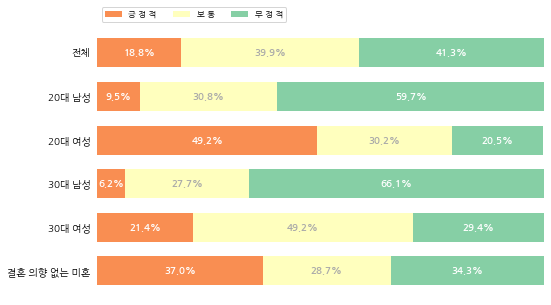

In [128]:
x = df.mul(100).to_dict(orient='split')
res = dict(zip(x['index'], x['data']))
cat = [' '.join(x) for x in x['columns']]
_ = plot_survey(res, cat, figsize=(8,5))

In [129]:
# 나이별 남녀인원수 동일하다는 가정하에 계산한 세대별 남녀수(예 20대 여자)는 (우연히도) 실제 20대 여자수와 동일

# 나이별 인원수와 남녀 비율 동일 가정
n_all = 1000 # 전체 응답자
n_single2 = 252 # 결혼 의향 없는 미혼
n_ages = round(n_all / (49-18+1) / 2) * 10 # 세대별 남자
n_ages

160

## CS1

In [134]:
nums = [n_all, n_ages, n_ages, n_ages, n_ages, n_single2]
method = 'normal'

c = 0
title = f'페미니즘에 {df.columns[c]} 비율:'
print(title)
for i in range(len(nums)):
    x = df.index[i]
    print_head(x, df.index)
    n = nums[i]
    k = round(df.iloc[i,c] * n)
    low, high = proportion_confint(k, n, alpha, method=method)
    print_interval(low, high, '')


페미니즘에 긍정적 비율:
전체		 0.188 ± 0.0242, [0.164, 0.212]
20대 남성	 0.094 ± 0.0452, [0.049, 0.139]
20대 여성	 0.494 ± 0.0775, [0.416, 0.571]
30대 남성	 0.062 ± 0.0375, [0.025, 0.100]
30대 여성	 0.212 ± 0.0634, [0.149, 0.276]
결혼 의향 없는 미혼	 0.369 ± 0.0596, [0.309, 0.429]


In [135]:
df2 = df.iloc[1:-1].mul(n_ages).apply(lambda x: round(x)).astype(int)
idx = df2.index.str.split(' ', expand=True)
x = df2.set_index(idx)
display(x)
    
evaluate_contingency(x, '페미니즘에 대한 태도')

긍정적  보통  부정적
20대 남성   15  49   96
    여성   79  48   33
30대 남성   10  44  106
    여성   34  79   47

H0:(20대) 성별과 페미니즘에 대한 태도의 상관관계가 없다	 Reject H0 (p-value = 7.1552e-17)
H0:(30대) 성별과 페미니즘에 대한 태도의 상관관계가 없다	 Reject H0 (p-value = 1.1330e-10)
H0:(남성) 세대와 페미니즘에 대한 태도의 상관관계가 없다	 Accept H0 (p-value = 4.1398e-01)
H0:(여성) 세대와 페미니즘에 대한 태도의 상관관계가 없다	 Reject H0 (p-value = 8.5802e-07)
H0:성별과 페미니즘에 대한 태도의 상관관계가 없다		 Reject H0 (p-value = 1.6312e-25)
H0:세대와 페미니즘에 대한 태도의 상관관계가 없다		 Reject H0 (p-value = 9.0241e-06)


## CS2
페미니즘에 긍정적인 응답자 가운데 70.1%가 결혼 의향이 없다고 밝혔다. 반면 페미니즘에 ‘보통’이거나 ‘부정적’인 태도를 갖는 사람들은 각각 63.5%, 65.2%가 결혼 의향이 있다고 응답했다

In [136]:
ps = [1-.701, .635, .652] # 페미니즘에 긍정/보통/부정적 태도를 가진 응답자의 결혼의향 있는 비율

In [137]:
nums = [n_all]*3
method = 'normal'

c = 0
title = f'결혼 의향 비율:'
print(title)
for i in range(len(nums)):
    x = df.iloc[0]
    print(f'페미니즘에 {x.index[i]}\t', end='')
    n = x[i] * nums[i]
    k = round(ps[i] * n)
    low, high = proportion_confint(k, n, alpha, method=method)
    print_interval(low, high, '')

결혼 의향 비율:
페미니즘에 긍정적	0.298 ± 0.0654, [0.233, 0.363]
페미니즘에 보통	0.634 ± 0.0473, [0.587, 0.681]
페미니즘에 부정적	0.651 ± 0.0460, [0.605, 0.697]


# F06 배우자의 페미니즘에 대한 태도
- 그림6 
- 대상 응답자 전체 1000명으로 가정 (그림에 표시 없음)
- 페미니즘에 대한 강한 의견(긍정 또는 부정)을 가질수록, 결혼 상대방의 태도를 민감하게 여긴다.
- 페미니즘에 대한 ‘긍정’ ‘부정’ 의견은 크게 성별로 나뉜다. 페미니즘에 긍정적인 여성은 페미니즘에 부정적인 남성을 원하지 않고, 페미니즘에 부정적인 남성은 마찬가지로 페미니즘에 긍정적인 여성을 원하지 않는다. 20대일수록, 이러한 경향성은 강화되고 있다.

comments:
- (기사대로) 페미니즘에 대한 강한 의견(긍정 또는 부정)을 가질수록, 결혼 상대방의 태도를 민감하게 여긴다.
- 배우자의 페미니즘에 대한 생각의 중요성은 세대 또는 성별 연관이 있다. 단 남성의 세대차는 없다.
- 페미니즘에 긍정적인 여성은 페미니즘에 부정적인 남성을 원하지 않고, 페미니즘에 부정적인 남성은 마찬가지로 페미니즘에 긍정적인 여성을 원하지 않는다. 20대일수록, 이러한 경향성은 강화되고 있다. => 기사의 데이터로는 확인할 수 없다(페미니즘에 대한 태도에 따른 배우자의 태도의 중요 비율에 대해 남녀 구별이 없음)

In [138]:
# 그림6: 배우자의 페미니즘 태도가 중요한가의 비율: 그렇다/그렇지않다
p1 = [.416, .479] 
p2 = [.608, .282] 
p3 = [.453, .410] 
p4 = [.584, .339]
p5 = [.244, .627]
p6 = [.545, .339] 
p7 = [.545, .408] # 페미니즘에 긍정적
p8 = [.179, .646] # 페미니즘에 보통
p9 = [.586, .349] # 페미니즘에 부정적

ps = [p1,p2,p3,p4,p5,p6,p7,p8,p9]
_ = [x.insert(1, 1-sum(x)) for x in ps]

idx = ['전체', '20대 남성', '20대 여성', '30대 남성', '30대 여성', '결혼 의향 없는 미혼', '페미니즘에 긍정적', '페미니즘에 보통','페미니즘에 부정적']
cols = ['그렇다', '기타', '그렇지 않다']
df = pd.DataFrame(ps, index=idx, columns=cols)

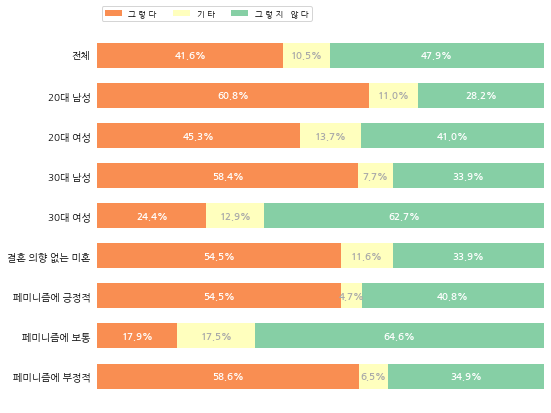

In [139]:
x = df.mul(100).to_dict(orient='split')
res = dict(zip(x['index'], x['data']))
cat = [' '.join(x) for x in x['columns']]
_ = plot_survey(res, cat, figsize=(8,7))

In [140]:
# 나이별 남녀인원수 동일하다는 가정하에 계산한 세대별 남녀수(예 20대 여자)는 (우연히도) 실제 20대 여자수와 동일

# 나이별 인원수와 남녀 비율 동일 가정
n_all = 1000 # 전체 응답자
n_single2 = 252 # 결혼 의향 없는 미혼
n_ages = round(n_all / (49-18+1) / 2) * 10 # 세대별 남자
n_ages

160

In [141]:
f = [.188, .399, .413] # 전체 1000명의 페미니즘에 대한 태도: 긍정/보통/부정  
f = [round(x*n_all) for x in f]

## CS1

In [142]:
nums = [n_all, n_ages, n_ages, n_ages, n_ages, n_single2, *f]
method = 'normal'

title = '배우자의 페미니즘에 대한 생각이 중요한가?: {}'

for c in range(len(df.columns)):
    print(title.format(df.columns[c]))
    for i in range(len(nums)):
        x = df.index[i]
        print_head(x, df.index)
        n = nums[i]
        k = round(df.iloc[i,c] * n)
        low, high = proportion_confint(k, n, alpha, method=method)
        print_interval(low, high, '')
    print()


배우자의 페미니즘에 대한 생각이 중요한가?: 그렇다
전체		 0.416 ± 0.0305, [0.385, 0.447]
20대 남성	 0.606 ± 0.0757, [0.531, 0.682]
20대 여성	 0.450 ± 0.0771, [0.373, 0.527]
30대 남성	 0.581 ± 0.0764, [0.505, 0.658]
30대 여성	 0.244 ± 0.0665, [0.177, 0.310]
결혼 의향 없는 미혼	 0.544 ± 0.0615, [0.482, 0.605]
페미니즘에 긍정적	 0.543 ± 0.0712, [0.471, 0.614]
페미니즘에 보통	 0.178 ± 0.0375, [0.140, 0.215]
페미니즘에 부정적	 0.586 ± 0.0475, [0.538, 0.633]

배우자의 페미니즘에 대한 생각이 중요한가?: 기타
전체		 0.105 ± 0.0190, [0.086, 0.124]
20대 남성	 0.113 ± 0.0490, [0.064, 0.161]
20대 여성	 0.138 ± 0.0534, [0.084, 0.191]
30대 남성	 0.075 ± 0.0408, [0.034, 0.116]
30대 여성	 0.131 ± 0.0523, [0.079, 0.184]
결혼 의향 없는 미혼	 0.115 ± 0.0394, [0.076, 0.154]
페미니즘에 긍정적	 0.048 ± 0.0305, [0.017, 0.078]
페미니즘에 보통	 0.175 ± 0.0373, [0.138, 0.213]
페미니즘에 부정적	 0.065 ± 0.0238, [0.042, 0.089]

배우자의 페미니즘에 대한 생각이 중요한가?: 그렇지 않다
전체		 0.479 ± 0.0310, [0.448, 0.510]
20대 남성	 0.281 ± 0.0697, [0.212, 0.351]
20대 여성	 0.412 ± 0.0763, [0.336, 0.489]
30대 남성	 0.338 ± 0.0733, [0.264, 0.411]
30대 여성	 0.625 ± 0.0750, [0.550, 0.

## CS2
세대 & 성별 연관성

In [143]:
df2 = df.iloc[1:-4].mul(n_ages).apply(lambda x: round(x)).astype(int)
idx = df2.iloc[:,0].index.str.split(' ', expand=True)
x = df2.set_index(idx)
display(x)
    
evaluate_contingency(x, '배우자의 페미니즘이 중요 여부')

그렇다  기타  그렇지 않다
20대 남성   97  18      45
    여성   72  22      66
30대 남성   93  12      54
    여성   39  21     100

H0:(20대) 성별과 배우자의 페미니즘이 중요 여부의 상관관계가 없다	 Reject H0 (p-value = 1.7675e-02)
H0:(30대) 성별과 배우자의 페미니즘이 중요 여부의 상관관계가 없다	 Reject H0 (p-value = 4.8636e-09)
H0:(남성) 세대와 배우자의 페미니즘이 중요 여부의 상관관계가 없다	 Accept H0 (p-value = 3.5006e-01)
H0:(여성) 세대와 배우자의 페미니즘이 중요 여부의 상관관계가 없다	 Reject H0 (p-value = 2.2510e-04)
H0:성별과 배우자의 페미니즘이 중요 여부의 상관관계가 없다		 Reject H0 (p-value = 2.0741e-09)
H0:세대와 배우자의 페미니즘이 중요 여부의 상관관계가 없다		 Reject H0 (p-value = 2.2482e-03)


## CS3

In [145]:
f = [.188, .399, .413] # 전체 1000명의 페미니즘에 대한 태도: 긍정/보통/부정  
f = [round(x*n_all) for x in f]

In [176]:
x = df.iloc[-3:]
x = (x.assign(n = pd.Series(f, index=x.index))
      .apply(lambda x: x[:3]*x[3], axis=1)
      .apply(lambda x: round(x)).astype(int))
display(x)

print('H0: 페미니즘에 대한 태도와 배우자의 태도의 중요성은 관계가 없다:')
res = stats.chi2_contingency(x)
test_hypothesis(res[1])

,그렇다,기타,그렇지 않다
페미니즘에 긍정적,102,9,77
페미니즘에 보통,71,70,258
페미니즘에 부정적,242,27,144


H0: 페미니즘에 대한 태도와 배우자의 태도의 중요성은 관계가 없다:
Reject H0 (p-value = 8.9336e-34)


# F06 배우자의 정치적 성향
- 20대 여성에게 특히 정치적 성향은 중요한 요건이다. 20대 여성 응답자 가운데 58.1%가 연애 상대방의 정치적 성향이 중요하다고 답했고, 66%는 결혼 상대방의 정치적 성향이 중요하다고 답했다. 같은 기준 20대 남성의 응답이 연애의 경우 42.2%, 결혼의 경우 40.9%라는 점을 감안하면 20대에서도 특히 여성들이 페미니즘과 같은 정치적 이슈에 대한 태도를 파트너 선택의 중요한 요건으로 삼는다는 걸 알 수 있다.

comments:
- 20대 여성에게 특히 정치적 성향은 20대 남성보다 중요한 요건이다.

In [177]:
p1 = [.422, .409] # 연애 상대방과 결혼 상대방의 정치적 성향이 중요하다는 비율
p2 = [.581, .66]

idx = ['20대 남성', '20대 여성']
cols = ['연애 상대방의 정치적 성향이 중요', '결혼 상대방의 정치적 성향이 중요']
df = pd.DataFrame([p1,p2], index=idx, columns=cols)

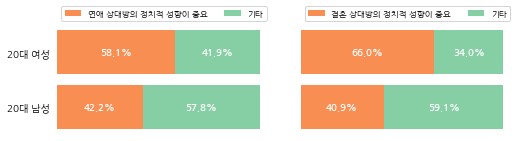

In [178]:
fig, axes = plt.subplots(1,2, figsize=(8,2), sharey=True)
for i in range(len(df.columns)):
    col = df.columns[i]
    x = (df.iloc[:,i].to_frame(col)
           .assign(disagree=lambda x: 1-x[col])
           .rename(columns={col:col, 'disagree': '기타'})
           .mul(100).to_dict(orient='split'))
    res = dict(zip(x['index'], x['data']))
    cat = x['columns']
    _ = plot_survey(res, cat, ax=axes[i], fig=fig)

In [179]:
# 나이별 남녀인원수 동일하다는 가정하에 계산한 세대별 남녀수(예 20대 여자)는 (우연히도) 실제 20대 여자수와 동일

# 나이별 인원수와 남녀 비율 동일 가정
n_all = 1000 # 전체 응답자
n_single2 = 252 # 결혼 의향 없는 미혼
n_ages = round(n_all / (49-18+1) / 2) * 10 # 세대별 남자
n_ages

160

In [180]:
nums = [n_ages, n_ages]
method = 'normal'

for c in range(len(df.columns)):
    print(f'{df.columns[c]}:')
    for i in range(len(nums)):
        x = df.index[i]
        print_head(x, df.index)
        n = nums[i]
        k = round(df.iloc[i,c] * n)
        low, high = proportion_confint(k, n, alpha, method=method)
        print_interval(low, high, '')
    print()

연애 상대방의 정치적 성향이 중요:
20대 남성 0.425 ± 0.0766, [0.348, 0.502]
20대 여성 0.581 ± 0.0764, [0.505, 0.658]

결혼 상대방의 정치적 성향이 중요:
20대 남성 0.406 ± 0.0761, [0.330, 0.482]
20대 여성 0.662 ± 0.0733, [0.589, 0.736]



In [181]:
df2 = df.copy()
idx = df2.index.str.split(' ', expand=True)
df2 = df2.set_index(idx)

for i in range(len(df2.columns)):
    col = df2.columns[i]
        
    x = (df2.iloc[:,i].to_frame(col)
            .assign(disagree=lambda x: 1-x[col])
            .rename(columns={col:col, 'disagree': '그외'})
            .mul(n_ages).apply(lambda x: round(x)).astype(int)
        )
    display(x)
    
    evaluate_contingency(x, col)
    
    print('\n'*1)

연애 상대방의 정치적 성향이 중요  그외
20대 남성                  68  92
    여성                  93  67

H0:(20대) 성별과 연애 상대방의 정치적 성향이 중요의 상관관계가 없다	 Reject H0 (p-value = 7.2892e-03)




결혼 상대방의 정치적 성향이 중요  그외
20대 남성                  65  95
    여성                 106  54

H0:(20대) 성별과 결혼 상대방의 정치적 성향이 중요의 상관관계가 없다	 Reject H0 (p-value = 7.3690e-06)




# F07 페미니즘의 악용으로 연애에 악영향
- "페미니즘이라는 것이 너무 정치적으로 악용돼서 남녀 간 건전한 교제 같은 것도 정서적으로 막는 역할을 많이 한다"는 윤 전 총장의 발언에 대해, 남성 응답자는 54.7%가 당시 발언에 동의한다고 답한 반면, 여성 응답자는 15.2%만이 동의한다고 답했다. 특히 20대 남녀의 반응이 극과 극이다. 20대 남성은 동의 59.9%, 동의하지 않음 26.8%인 반면, 20대 여성은 동의 11.8%, 동의하지 않음 72.2%를 보였다. 

comments:
- 20대 남녀의 반응은 전체 남녀의 반응과 차이가 없다.

In [182]:
p1 = [.547] # 남성 동의
p2 = [.152] # 여성 동의
p3 = [.599] # 20대 남성 동의
p4 = [.118] # 20대 여성 동의
ps = [p1,p2,p3,p4]
_ = [x.append(1-x[0]) for x in ps]

idx = ['남성', '여성', '20대 남성', '20대 여성']
cols = ['페미니즘의 악용이 연애를 막는다','기타']
df = pd.DataFrame(ps, index=idx, columns=cols)
df

,페미니즘의 악용이 연애를 막는다,기타
남성,0.547,0.453
여성,0.152,0.848
20대 남성,0.599,0.401
20대 여성,0.118,0.882


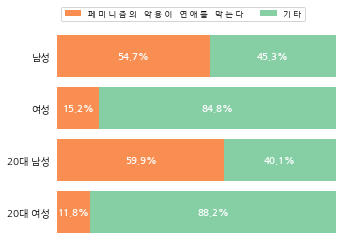

In [183]:
x = df.mul(100).to_dict(orient='split')
res = dict(zip(x['index'], x['data']))
cat = [' '.join(x) for x in x['columns']]
_ = plot_survey(res, cat, figsize=(5,4))

In [184]:
# 나이별 남녀인원수 동일하다는 가정하에 계산한 세대별 남녀수(예 20대 여자)는 (우연히도) 실제 20대 여자수와 동일

# 나이별 인원수와 남녀 비율 동일 가정
n_all = 1000 # 전체 응답자
n_sex = round(n_all/2) # 남녀 비율 동일 가정
n_ages = round(n_all / (49-18+1) / 2) * 10 # 세대별 남자

n_sex, n_ages

(500, 160)

In [185]:
nums = [n_sex, n_sex, n_ages, n_ages]
method = 'normal'

c = 0
print(f'{df.columns[c]}에 동의:')
for i in range(len(nums)):
    x = df.index[i]
    print_head(x, df.index, n_tab=2)
    n = nums[i]
    k = round(df.iloc[i,c] * n)
    low, high = proportion_confint(k, n, alpha, method=method)
    print_interval(low, high, '')

페미니즘의 악용이 연애를 막는다에 동의:
남성		 0.548 ± 0.0436, [0.504, 0.592]
여성		 0.152 ± 0.0315, [0.121, 0.183]
20대 남성	 0.600 ± 0.0759, [0.524, 0.676]
20대 여성	 0.119 ± 0.0501, [0.069, 0.169]


In [186]:
df2 = df.copy()
df2.index = ['전체 남성', '전체 여성'] + df.index.tolist()[2:]
idx = df2.index.str.split(' ', expand=True)
df2 = df2.set_index(idx)
df2

페미니즘의 악용이 연애를 막는다     기타
전체  남성              0.547  0.453
    여성              0.152  0.848
20대 남성              0.599  0.401
    여성              0.118  0.882

In [187]:
q = '페미니즘의 악용이 연애를 막는다'
x = df2.iloc[:2].mul(n_sex).apply(lambda x: round(x)).astype(int)
display(x)
evaluate_contingency(x, q)

x = df2.iloc[2:].mul(n_ages).apply(lambda x: round(x)).astype(int)
display(x)
evaluate_contingency(x, q)

페미니즘의 악용이 연애를 막는다   기타
전체 남성                274  226
   여성                 76  424

H0:(전체) 성별과 페미니즘의 악용이 연애를 막는다의 상관관계가 없다	 Reject H0 (p-value = 5.5020e-39)


페미니즘의 악용이 연애를 막는다   기타
20대 남성                 96   64
    여성                 19  141

H0:(20대) 성별과 페미니즘의 악용이 연애를 막는다의 상관관계가 없다	 Reject H0 (p-value = 8.4080e-19)


# F08 결혼에 대한 불안감
- 그림7 
- 대상 응답자 미혼 579명
- (그림에 없는 내용)‘결혼 의향 없는 미혼’ 집단에서 ‘자녀 때문에 시간을 자유롭게 쓰지 못할까 봐 불안하다’는 응답은 58.6%를 차지한다. 전체 평균이 39.5%라는 점을 감안하면 확실히 이들 집단의 불안감이 유독 크다고 볼 수 있다. 
- (그림에 없는 내용)‘자녀 때문에 돈을 자유롭게 쓰지 못할 것 같아 우려된다’는 응답도 이들 ‘결혼 의향 없는 미혼’ 집단에서 49.2%를 기록했다. 이 질문에 대해서도 전체 응답자 평균은 34.4%에 불과하다.
- (그림에 없는 내용)‘결혼할 경우 내 커리어에 악영향을 미칠까 봐 불안감을 느낀다’ ‘자녀가 내 커리어에 악영향을 미칠까 봐 불안감을 느낀다’. ‘결혼 의향 없는 미혼’ 집단에서 ‘그렇다’고 응답한 비율은 각각 44%, 28.6%다. 여기서 다소 흥미로운 것은 ‘자녀’보다 ‘결혼’의 악영향을 더 크게 느낀다는 점이다. 결혼할 의향이 없는 사람들이 아이의 존재 자체를 거북하게 여기는 것은 아니다. 애들에게는 문제가 없다. 커리어를 망칠지 모른다는 불안의 근원은 아이가 아니라 결혼이라는 시스템에 있다.
- 미혼 응답자(579명)에게 결혼하지 않는 삶이 주는 불안감을 물었다. ‘나이를 먹었을 때 외로움’ ‘주변 사람들의 시선’ ‘사회적 불이익’ ‘경제적 불이익’ 네 측면에서 불안감을 측정했다. 결과는 각각 48.4%, 29.3%, 24.4%, 24.1%. 네 가지 응답에서 특별히 성별·세대별 특징은 도출되지 않았다. 외로울지 모른다는 막연한 불안을 제외하면, 나머지 불안감은 전반적으로 약한 수준이다. => 차이가 명확해 보여 별도 분석 제외.

comments:
- 결혼 의향 없는 미혼 집단은 결혼/자녀로 인한 시간/경제력 부족 우려와 결혼으로 인한 커리어 악영향에 대한 우려가 전체 응답자의 우려보다 더 크다. 
- 결혼 의향 없는 미혼에 대하여 커리어를 망칠지 모른다는 불안은 아이보다 결혼에서 더 크다고 할 수 있다.
- 결혼 의향 없는 미혼에 대하여 결혼으로 자유 시간 부족을 가장 우려하고, 자녀때문에 자유 시간 부족과 경제적 부자유를 더 걱정한다. 

In [188]:
# 결혼으로 자유시간 부족 우려, 결혼으로 경제적 부자유 우려, 결혼으로 커리어 악영향 우려, 자녀때문에 자유시간 부족 우려, 자녀때문에 경제적 부자유 우려  긍정 비율
p1 = [.514, .371, .301, .395, .344] # 전체
p2 = [.69, .501, .44, .586, .492] # 결혼 의향 없는 미혼

idx = ['전체', '결혼 의향 없는 미혼']
#cols = ['결혼으로 자유시간 부족 우려', '결혼으로 경제적 부자유 우려', '결혼으로 커리어 악영향 우려','자녀때문에 자유시간 부족 우려', '자녀때문에 경제적 부자유 우려']
cols = [['결혼으로']*3 + ['자녀때문에']*2, ['자유시간 부족 우려', '경제적 부자유 우려', '커리어 악영향 우려','자유시간 부족 우려', '경제적 부자유 우려']]
df = pd.DataFrame([p1,p2], index=idx, columns=cols)

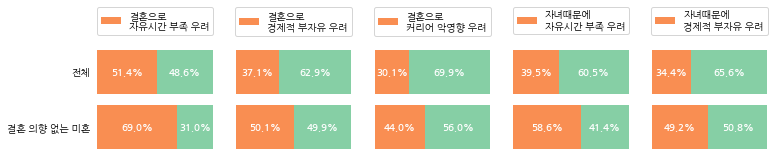

In [189]:
bbox_to_anchor=(0.5, 1.4)

fig, axes = plt.subplots(1,5, figsize=(12,2), sharey=True)
for i in range(len(df.columns)):
    col = df.columns[i]
    x = (df.iloc[:,i].to_frame(col)
           .assign(disagree=lambda x: 1-x[col])
           .rename(columns={col:col, 'disagree': '기타'})
           .mul(100).to_dict(orient='split'))
    res = dict(zip(x['index'], x['data']))
    cat = ['\n'.join(x) for x in x['columns']]
    ax = plot_survey(res, cat, ax=axes[i], fig=fig)
    
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[0:1], l[0:1], loc='upper center', bbox_to_anchor=bbox_to_anchor)
    #ax.legend(h[0:1], l[0:1], loc='upper center', bbox_to_anchor=ax.get_legend().get_bbox_to_anchor())

In [190]:
n_all = 1000 # 전체 응답자
n_single2 = 252 # 결혼 의향 없는 미혼

## CS1

In [191]:
nums = [n_all, n_single2]
method = 'normal'

for c in range(len(df.columns)):
    t = ' '.join(df.columns[c])
    print(f'{t} 긍정 비율:')
    for i in range(len(nums)):
        x = df.index[i]
        print_head(x, df.index)
        n = nums[i]
        k = round(df.iloc[i,c] * n)
        low, high = proportion_confint(k, n, alpha, method=method)
        print_interval(low, high, '')
    print()

결혼으로 자유시간 부족 우려 긍정 비율:
전체		 0.514 ± 0.0310, [0.483, 0.545]
결혼 의향 없는 미혼	 0.690 ± 0.0571, [0.633, 0.748]

결혼으로 경제적 부자유 우려 긍정 비율:
전체		 0.371 ± 0.0299, [0.341, 0.401]
결혼 의향 없는 미혼	 0.500 ± 0.0617, [0.438, 0.562]

결혼으로 커리어 악영향 우려 긍정 비율:
전체		 0.301 ± 0.0284, [0.273, 0.329]
결혼 의향 없는 미혼	 0.440 ± 0.0613, [0.379, 0.502]

자녀때문에 자유시간 부족 우려 긍정 비율:
전체		 0.395 ± 0.0303, [0.365, 0.425]
결혼 의향 없는 미혼	 0.587 ± 0.0608, [0.527, 0.648]

자녀때문에 경제적 부자유 우려 긍정 비율:
전체		 0.344 ± 0.0294, [0.315, 0.373]
결혼 의향 없는 미혼	 0.492 ± 0.0617, [0.430, 0.554]



## CS2
결혼 의향 없는 미혼

In [192]:
r = pd.Series([.286], index=[['자녀때문에'], ['커리어 악영향 우려']])
df_tmp = pd.concat([df.iloc[1], r])

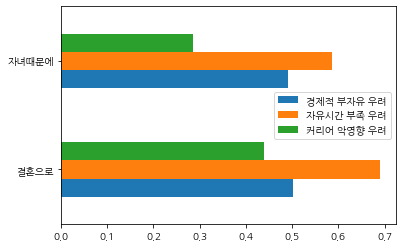

In [193]:
_ = df_tmp.unstack(level=-1).plot(kind='barh')

In [194]:
print('결혼 의향 없는 미혼:')
n = n_single2
idx = [' '.join(x) for x in df_tmp.index]
for i in range(len(df_tmp)):
    print_head(idx[i], idx)
    k = round(df_tmp[i] * n)
    low, high = proportion_confint(k, n, alpha, method=method)
    print_interval(low, high, '')

결혼 의향 없는 미혼:
결혼으로 자유시간 부족 우려	 0.690 ± 0.0571, [0.633, 0.748]
결혼으로 경제적 부자유 우려	 0.500 ± 0.0617, [0.438, 0.562]
결혼으로 커리어 악영향 우려	 0.440 ± 0.0613, [0.379, 0.502]
자녀때문에 자유시간 부족 우려	 0.587 ± 0.0608, [0.527, 0.648]
자녀때문에 경제적 부자유 우려	 0.492 ± 0.0617, [0.430, 0.554]
자녀때문에 커리어 악영향 우려	 0.286 ± 0.0558, [0.230, 0.341]


In [195]:
df2 = df_tmp.mul(n_single2).apply(lambda x: round(x)).astype(int)

print('결혼 의향 없는 미혼:')

x = df2.unstack(level=-1)
display(x)

idx = [f'{x} 인한 우려들' for x in x.index]
for i in range(len(idx)):
    print_head(idx[i], idx)
    res = stats.chisquare(x.iloc[i])
    test_hypothesis(res[1])

결혼 의향 없는 미혼:


,경제적 부자유 우려,자유시간 부족 우려,커리어 악영향 우려
결혼으로,126,174,111
자녀때문에,124,148,72


결혼으로 인한 우려들	 Reject H0 (p-value = 3.6885e-04)
자녀때문에 인한 우려들 Reject H0 (p-value = 1.9208e-06)


# F09 자녀에 대한 자신감
- 그림8 
- 대상 응답자 전체 1000명
- (그림에 없는 내용)‘훗날 이혼할 가능성이 있다면 결혼을 아예 피하는 편이 낫다’와 ‘훗날 이혼할 가능성이 있더라도 결혼을 피할 필요는 없다’는 양자택일 질문을 던졌다. 전체 응답자의 39.3%가 피하는 게 낫다고, 60.7%는 굳이 피할 필요는 없다고 답했다... 그러나 ‘결혼 의향 없는 미혼’ 집단의 생각은 달랐다. 이들은 절반 이상인 58.2%가 ‘결혼을 피하는 게 낫다’고 답했다.
- (그림에 없는 내용)‘한국에서는 한번 실패하면 재기가 어렵다’는 질문에 대한 응답에서도 ‘결혼 의향 없는 미혼’ 집단의 답변이 튄다. 전체 응답자는 ‘그렇다’ 50.4%, ‘그렇지 않다’ 44.4%로 비등비등하다. 하지만 ‘결혼 의향 없는 미혼’ 집단에서는 61.9%가 ‘그렇다’고 답했다.

comments:
- 모든 항목에 대하여 결혼 의향 없는 미혼이 전체 응답자보다 더 부정적.

In [196]:
p1 = [.621, .451, .528, .571, .393, .504] # 전체
p2 = [.336, .238, .635, .798, .582, .619] # 결혼 의향 없는 미혼

idx = ['전체', '결혼 의향 없는 미혼']
cols = ['자녀와 행복에 자신', '자녀 교육에 자신', '자녀의 경제적 부족함에 불안','누군가에 대한 책임 부담', '이혼 우려시 결혼 회피', '한국은 재기가 어렵다']
df = pd.DataFrame([p1,p2], index=idx, columns=cols)

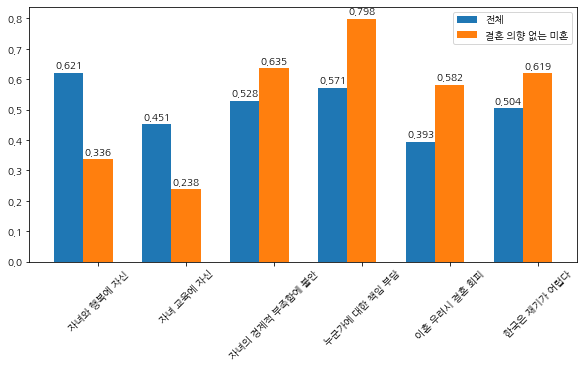

In [197]:
plot_groupbar(df, figsize=(8,5))

In [198]:
n_all = 1000 # 전체 응답자
n_single2 = 252 # 결혼 의향 없는 미혼

In [199]:
nums = [n_all, n_single2]
method = 'normal'

for c in range(len(df.columns)):
    t = df.columns[c]
    print(f'{t} 긍정 비율:')
    for i in range(len(nums)):
        x = df.index[i]
        print_head(x, df.index)
        n = nums[i]
        k = round(df.iloc[i,c] * n)
        low, high = proportion_confint(k, n, alpha, method=method)
        print_interval(low, high, '')
    print()

자녀와 행복에 자신 긍정 비율:
전체		 0.621 ± 0.0301, [0.591, 0.651]
결혼 의향 없는 미혼	 0.337 ± 0.0584, [0.279, 0.396]

자녀 교육에 자신 긍정 비율:
전체		 0.451 ± 0.0308, [0.420, 0.482]
결혼 의향 없는 미혼	 0.238 ± 0.0526, [0.186, 0.291]

자녀의 경제적 부족함에 불안 긍정 비율:
전체		 0.528 ± 0.0309, [0.497, 0.559]
결혼 의향 없는 미혼	 0.635 ± 0.0594, [0.575, 0.694]

누군가에 대한 책임 부담 긍정 비율:
전체		 0.571 ± 0.0307, [0.540, 0.602]
결혼 의향 없는 미혼	 0.798 ± 0.0496, [0.748, 0.847]

이혼 우려시 결혼 회피 긍정 비율:
전체		 0.393 ± 0.0303, [0.363, 0.423]
결혼 의향 없는 미혼	 0.583 ± 0.0609, [0.522, 0.644]

한국은 재기가 어렵다 긍정 비율:
전체		 0.504 ± 0.0310, [0.473, 0.535]
결혼 의향 없는 미혼	 0.619 ± 0.0600, [0.559, 0.679]



# F10 주관적 계층 인식
- 주관적 계층 인식이다. 미혼 응답자 가운데 자신을 상위층이라고 여기는 이들은 73.1%가 결혼할 의향이 있다고 답했다. 중간층이라고 답한 이들도 62.8%가 결혼에 의향이 있었다. 반면 중하위층(50.3%)과 최하위층(51.8%)은 상대적으로 결혼에 대한 의향이 떨어졌다. 다만 이것은 소득과 재산을 기준으로 나눈 계급과 다르다. 

comments:
- 각 계층 인식별 인원수를 알수 없어 오차 범위를 계산할 수 없다.

In [200]:
# 미혼의 결혼의향 있음
p1 = [.731] # 상위층
p2 = [.628] # 중간층
p3 = [.503] # 중하위층
p4 = [.518] # 최하위층
ps = [p1, p2, p3, p4]

idx = ['상위층', '중간층', '중하위층', '최하위층']
cols = ['미혼의 결혼의향 있음']
df = pd.DataFrame(ps, index=idx, columns=cols)

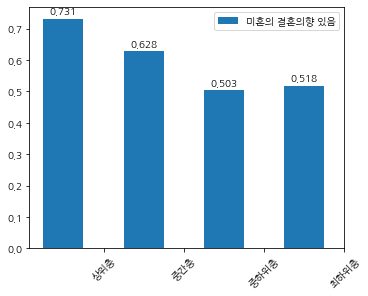

In [201]:
plot_groupbar(df, figsize=(5,4), axis=1)